In [1]:
!pip install -U langgraph  langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 9.3 MB/s eta 0:00:00


### Defining The State

In [2]:
from typing import TypedDict

class GraphState(TypedDict):
  input: str
  assigned_node: int
  prev_node_to_write: str

### Nodes

In [3]:
import random

def bad_manager_node(state):
  node_num = random.randint(1,2)
  return dict(input=state['input'],
              assigned_node=node_num,
              prev_node_to_write="manager")

def node_1(state):
  return dict(input=state['input'],
              assigned_node=1 if 'node 1' in state['input'].content else 2,
              prev_node_to_write="node 1")

def node_2(state):
  return dict(input=state['input'],
              assigned_node=2 if 'node 2' in state['input'].content else 1,
              prev_node_to_write="node 2")

### Edges

In [4]:
from typing import Literal
from langgraph.graph import END

def bad_manager_node_assigner(state) -> Literal["node 1", "node 2"]:
  assigned_node = state['assigned_node']
  if assigned_node == 1:
    return "node 1"
  elif assigned_node == 2:
    return "node 2"

# define the routing functions for the worker nodes

def should_reassign_1(state) -> Literal["node 2", END]:
  assigned_node = state['assigned_node']
  if assigned_node != 1:
    return "node 2"

  return END

def should_reassign_2(state) -> Literal["node 1", END]:
  assigned_node = state['assigned_node']
  if assigned_node != 2:
    return "node 1"

  return END

### Build Graph

In [5]:
from langgraph.graph import StateGraph

workflow = StateGraph(GraphState)

# add nodes
workflow.add_node("manager", bad_manager_node)
workflow.add_node("node 1", node_1)
workflow.add_node("node 2", node_2)

# set an entrypoint
workflow.set_entry_point("manager")

# add edges
workflow.add_conditional_edges("manager",
                               bad_manager_node_assigner)
workflow.add_conditional_edges("node 1",
                               should_reassign_1)
workflow.add_conditional_edges("node 2",
                               should_reassign_2)

graph = workflow.compile()

### Visualize Graph

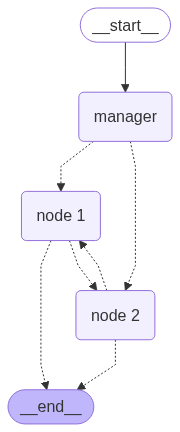

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Test The Graph!

In [8]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": 6}}

input_message = HumanMessage(content="assign this task to node 1")

for event in graph.stream({"input": input_message}, config, stream_mode="values"):
  print(event)

{'input': HumanMessage(content='assign this task to node 1', additional_kwargs={}, response_metadata={})}
{'input': HumanMessage(content='assign this task to node 1', additional_kwargs={}, response_metadata={}), 'assigned_node': 2, 'prev_node_to_write': 'manager'}
{'input': HumanMessage(content='assign this task to node 1', additional_kwargs={}, response_metadata={}), 'assigned_node': 1, 'prev_node_to_write': 'node 2'}
{'input': HumanMessage(content='assign this task to node 1', additional_kwargs={}, response_metadata={}), 'assigned_node': 1, 'prev_node_to_write': 'node 1'}
